In [69]:
import numpy as np # linear algebra
import pandas as pd # data processing, 
import os

In [70]:
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms as T # for simplifying the transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models

In [71]:
# remove warnings
import warnings
warnings.filterwarnings("ignore")

In [72]:
import matplotlib.pyplot as plt
%matplotlib inline
# Data Visualization
import plotly.express as px

In [73]:
import sys
from tqdm import tqdm
import time
import copy

In [74]:
def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

In [75]:
import torch
import torchvision.transforms as T
from torch.utils.data import DataLoader, random_split

def get_data_loaders(data_dir, batch_size, train = False):
    if train:
        #train
        transform = T.Compose([
            #T.RandomHorizontalFlip(),
            #T.RandomVerticalFlip(),
            #T.RandomApply(torch.nn.ModuleList([T.ColorJitter()]), p=0.20),
            #T.RandomRotation(degrees=(-45, 45)),
            #T.RandomResizedCrop(size=(384, 384), scale=(0.8, 1.0), ratio=(0.75, 1.3333)),
            #T.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=(-10, 10)),
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet means and standard deviations
    # T.RandomErasing(p=0.2, value='random')  # You can uncomment this line if needed
        ])
        train_data = datasets.ImageFolder(os.path.join(data_dir, "/kaggle/input/all-dataset2-splitted/ALL_Splitted/train/"), transform = transform)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return train_loader, len(train_data)
    else:
        # val/test
        transform = T.Compose([ # We dont need augmentation for test transforms
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
        ])
        val_data = datasets.ImageFolder(os.path.join(data_dir, "/kaggle/input/all-dataset2-splitted/ALL_Splitted/val/"), transform=transform)
        test_data = datasets.ImageFolder(os.path.join(data_dir, "/kaggle/input/all-dataset2-splitted/ALL_Splitted/test/"), transform=transform)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4)
        return val_loader, test_loader, len(val_data), len(test_data)

In [76]:
dataset_path = "/kaggle/input/all-dataset2-splitted/ALL_Splitted/train/"

In [77]:
(train_loader, train_data_len) = get_data_loaders(dataset_path, 32, train=True)
(val_loader, test_loader, valid_data_len, test_data_len) = get_data_loaders(dataset_path, 32, train=False)

In [78]:
classes = get_classes("/kaggle/input/all-dataset2-splitted/ALL_Splitted/train/")

In [11]:
# Get Class Names
class_names = sorted(os.listdir(dataset_path))
n_classes = len(class_names)

# Show
print(f"Class Names : {class_names}")
print(f"Number of Classes  : {n_classes}")

Class Names : ['Benign', 'Early', 'Pre', 'Pro']
Number of Classes  : 4


In [79]:
# Calculate class distribution
class_dis = [len(os.listdir(dataset_path + name)) for name in class_names]
class_dis

[302, 591, 577, 482]

In [80]:
# Visualization
fig = px.pie(names=class_names, values=class_dis, title="Training Class Distribution")
fig.update_layout({'title':{'x':0.45}})
fig.show()

In [81]:
pred_dataset_path = "/kaggle/input/all-dataset2-splitted/ALL_Splitted/test/"
# Calculate class distribution
class_dis = [len(os.listdir(pred_dataset_path + name)) for name in class_names]

# Visualization
fig = px.pie(names=class_names, values=class_dis, title="Prediction Class Distribution")
fig.update_layout({'title':{'x':0.45}})
fig.show()

In [82]:
dataloaders = {
    "train": train_loader,
    "val": val_loader
}
dataset_sizes = {
    "train": train_data_len,
    "val": valid_data_len
}

In [83]:
print(len(train_loader), len(val_loader), len(test_loader))

61 21 21


In [84]:
print(train_data_len, valid_data_len, test_data_len)

1952 649 655


In [85]:
# now, for the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [86]:
## Now, we import timm, torchvision image models
!pip install timm # kaggle doesnt have it installed by default
import timm

#timm.list_models('**')

model = timm.create_model('vit_base_patch16_224.orig_in21k_ft_in1k', pretrained=True)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [87]:
print(model)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [88]:
import torch.nn as nn

for param in model.parameters():
    param.requires_grad = False

n_inputs = model.head.in_features
model.head = nn.Sequential(
    nn.Linear(n_inputs, 512),
    nn.Linear(512, len(classes))
)
model = model.to(device)
print(model.head)

Sequential(
  (0): Linear(in_features=768, out_features=512, bias=True)
  (1): Linear(in_features=512, out_features=4, bias=True)
)


In [89]:
criterion =  nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = optim.Adam(model.head.parameters(), lr=0.001)

# lr scheduler
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

In [90]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report, cohen_kappa_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import time
import copy
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
!pip install seaborn
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, classification_report, cohen_kappa_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

import time
import copy
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

def train_model(model, criterion, optimizer, scheduler, num_epochs=100, patience=500):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    no_improvement_count = 0

    val_true_labels = []
    val_pred_labels = []
    val_pred_probs = []
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print("-" * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                if phase == 'val':
                    val_true_labels += labels.tolist()
                    val_pred_labels += preds.tolist()
                    val_pred_probs += torch.softmax(outputs, dim=1).tolist()

            if phase == 'train':
                train_loss_history.append(running_loss / dataset_sizes[phase])
            else:
                val_loss_history.append(running_loss / dataset_sizes[phase])

            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, running_loss / dataset_sizes[phase], epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict()) # keep the best validation accuracy model
                no_improvement_count = 0
            elif phase == 'val':
                no_improvement_count += 1

            if phase == 'train':
                train_acc_history.append(epoch_acc.item())
            else:
                val_acc_history.append(epoch_acc.item())

        print()

        if no_improvement_count >= patience:
            print(f"No improvement in validation accuracy for {no_improvement_count} epochs. Early stopping...")
            break

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Best Val Acc: {:.4f}".format(best_acc))

    model.load_state_dict(best_model_wts)


    # Calculate confusion matrix, F1 score, sensitivity, specificity, accuracy, and Cohen's kappa
    confusion_mat = confusion_matrix(val_true_labels, val_pred_labels)
    f1 = f1_score(val_true_labels, val_pred_labels, average='weighted')
    sensitivity = confusion_mat.diagonal() / confusion_mat.sum(axis=1)
    specificity = np.diag(confusion_mat) / np.sum(confusion_mat, axis=1)
    accuracy = np.sum(np.diag(confusion_mat)) / np.sum(confusion_mat)
    true_positives = np.diag(confusion_mat)
    true_negatives = np.sum(confusion_mat) - (np.sum(true_positives) + np.sum(confusion_mat.sum(axis=0)) - np.sum(true_positives))
    false_positives = confusion_mat.sum(axis=0) - true_positives
    false_negatives = confusion_mat.sum(axis=1) - true_positives
    kappa = cohen_kappa_score(val_true_labels, val_pred_labels)

    # Print confusion matrix, F1 score, sensitivity, specificity, accuracy, and Cohen's kappa
    print("Confusion Matrix:")
    print(confusion_mat)
    print("F1 Score: {:.4f}".format(f1))
    print("Sensitivity (Recall):", sensitivity)
    print("Specificity:", specificity)
    print("Accuracy: {:.4f}".format(accuracy))
    print("True Positives:", true_positives)
    print("True Negatives:", true_negatives)
    print("False Positives:", false_positives)
    print("False Negatives:", false_negatives)
    print("Cohen's Kappa:", kappa)


    # Print classification report
    target_names = [str(i) for i in range(len(classes))]
    print(classification_report(val_true_labels, val_pred_labels, target_names=target_names))
    
    
    
    # Set Seaborn style
    sns.set(style="darkgrid")
    # Plot accuracy curves
    plt.figure(figsize=(10, 5))
    sns.lineplot(x=range(1, len(train_acc_history) + 1), y=train_acc_history, label='Train', linestyle='-', color='#2C5D63')
    sns.lineplot(x=range(1, len(val_acc_history) + 1), y=val_acc_history, label='Validation', linestyle='-', color='#6C5F5B')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()
    
    # Plot loss curves
    plt.figure(figsize=(10, 5))
    sns.lineplot(x=range(1, len(train_loss_history) + 1), y=train_loss_history, label='Train', linestyle='-', color='#2C5D63')
    sns.lineplot(x=range(1, len(val_loss_history) + 1), y=val_loss_history, label='Validation', linestyle='-', color='#6C5F5B')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


    confusion_mat = confusion_matrix(val_true_labels, val_pred_labels, labels=np.arange(len(classes)))
    # Plot customized confusion matrix
    plt.figure(figsize=(8, 8))
    sns.heatmap(confusion_mat, annot=True, fmt=".0f", cmap="YlGn", linewidths=.5, square=True, cbar=False,
                xticklabels=classes, yticklabels=classes)
    
    plt.title('Confusion Matrix', fontsize=16)
    plt.xlabel('Predicted label', fontsize=12)
    plt.ylabel('True label', fontsize=12)
    
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0, ha='right')
    
    plt.tight_layout()
    plt.show()

Epoch 0/99
----------


100%|██████████| 61/61 [00:12<00:00,  5.01it/s]


train Loss: 0.2395 Acc: 0.9242


100%|██████████| 21/21 [00:04<00:00,  4.80it/s]


val Loss: 0.0703 Acc: 0.9738

Epoch 1/99
----------


100%|██████████| 61/61 [00:12<00:00,  5.00it/s]


train Loss: 0.0426 Acc: 0.9872


100%|██████████| 21/21 [00:04<00:00,  4.78it/s]


val Loss: 0.0660 Acc: 0.9831

Epoch 2/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.83it/s]


train Loss: 0.0380 Acc: 0.9887


100%|██████████| 21/21 [00:04<00:00,  4.71it/s]


val Loss: 0.0303 Acc: 0.9892

Epoch 3/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.93it/s]


train Loss: 0.0129 Acc: 0.9954


100%|██████████| 21/21 [00:04<00:00,  4.76it/s]


val Loss: 0.0239 Acc: 0.9923

Epoch 4/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.93it/s]


train Loss: 0.0215 Acc: 0.9949


100%|██████████| 21/21 [00:04<00:00,  4.75it/s]


val Loss: 0.0174 Acc: 0.9954

Epoch 5/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.96it/s]


train Loss: 0.0135 Acc: 0.9959


100%|██████████| 21/21 [00:04<00:00,  4.77it/s]


val Loss: 0.0190 Acc: 0.9954

Epoch 6/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.97it/s]


train Loss: 0.0035 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.77it/s]


val Loss: 0.0177 Acc: 0.9954

Epoch 7/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.98it/s]


train Loss: 0.0016 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.78it/s]


val Loss: 0.0126 Acc: 0.9954

Epoch 8/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.98it/s]


train Loss: 0.0012 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.74it/s]


val Loss: 0.0160 Acc: 0.9954

Epoch 9/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.97it/s]


train Loss: 0.0009 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.76it/s]


val Loss: 0.0157 Acc: 0.9954

Epoch 10/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.96it/s]


train Loss: 0.0014 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.75it/s]


val Loss: 0.0233 Acc: 0.9923

Epoch 11/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.98it/s]


train Loss: 0.0014 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.73it/s]


val Loss: 0.0124 Acc: 0.9954

Epoch 12/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.92it/s]


train Loss: 0.0006 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.76it/s]


val Loss: 0.0194 Acc: 0.9938

Epoch 13/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.97it/s]


train Loss: 0.0004 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.74it/s]


val Loss: 0.0201 Acc: 0.9938

Epoch 14/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.98it/s]


train Loss: 0.0004 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.79it/s]


val Loss: 0.0152 Acc: 0.9954

Epoch 15/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.96it/s]


train Loss: 0.0003 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.72it/s]


val Loss: 0.0158 Acc: 0.9954

Epoch 16/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.96it/s]


train Loss: 0.0003 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.77it/s]


val Loss: 0.0141 Acc: 0.9954

Epoch 17/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.97it/s]


train Loss: 0.0003 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.72it/s]


val Loss: 0.0163 Acc: 0.9954

Epoch 18/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.97it/s]


train Loss: 0.0002 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.75it/s]


val Loss: 0.0147 Acc: 0.9954

Epoch 19/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.95it/s]


train Loss: 0.0002 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.76it/s]


val Loss: 0.0182 Acc: 0.9954

Epoch 20/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.97it/s]


train Loss: 0.0002 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.76it/s]


val Loss: 0.0159 Acc: 0.9954

Epoch 21/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.97it/s]


train Loss: 0.0002 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.75it/s]


val Loss: 0.0180 Acc: 0.9954

Epoch 22/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.94it/s]


train Loss: 0.0002 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.75it/s]


val Loss: 0.0143 Acc: 0.9954

Epoch 23/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.96it/s]


train Loss: 0.0002 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.77it/s]


val Loss: 0.0158 Acc: 0.9954

Epoch 24/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.97it/s]


train Loss: 0.0002 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.74it/s]


val Loss: 0.0142 Acc: 0.9954

Epoch 25/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.96it/s]


train Loss: 0.0001 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.76it/s]


val Loss: 0.0172 Acc: 0.9954

Epoch 26/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.96it/s]


train Loss: 0.0001 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.76it/s]


val Loss: 0.0161 Acc: 0.9954

Epoch 27/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.97it/s]


train Loss: 0.0001 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.76it/s]


val Loss: 0.0147 Acc: 0.9954

Epoch 28/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.97it/s]


train Loss: 0.0001 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.75it/s]


val Loss: 0.0181 Acc: 0.9954

Epoch 29/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.97it/s]


train Loss: 0.0001 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.76it/s]


val Loss: 0.0166 Acc: 0.9954

Epoch 30/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.97it/s]


train Loss: 0.0001 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.73it/s]


val Loss: 0.0163 Acc: 0.9954

Epoch 31/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.97it/s]


train Loss: 0.0001 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.74it/s]


val Loss: 0.0181 Acc: 0.9954

Epoch 32/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.96it/s]


train Loss: 0.0001 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.74it/s]


val Loss: 0.0167 Acc: 0.9954

Epoch 33/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.96it/s]


train Loss: 0.0001 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.77it/s]


val Loss: 0.0166 Acc: 0.9954

Epoch 34/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.95it/s]


train Loss: 0.0001 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.64it/s]


val Loss: 0.0159 Acc: 0.9954

Epoch 35/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.97it/s]


train Loss: 0.0001 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.73it/s]


val Loss: 0.0160 Acc: 0.9954

Epoch 36/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.97it/s]


train Loss: 0.0001 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.77it/s]


val Loss: 0.0176 Acc: 0.9954

Epoch 37/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.97it/s]


train Loss: 0.0001 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.74it/s]


val Loss: 0.0178 Acc: 0.9954

Epoch 38/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.96it/s]


train Loss: 0.0001 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.73it/s]


val Loss: 0.0170 Acc: 0.9954

Epoch 39/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.95it/s]


train Loss: 0.0001 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.75it/s]


val Loss: 0.0175 Acc: 0.9954

Epoch 40/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.97it/s]


train Loss: 0.0001 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.75it/s]


val Loss: 0.0170 Acc: 0.9954

Epoch 41/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.97it/s]


train Loss: 0.0001 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.76it/s]


val Loss: 0.0178 Acc: 0.9954

Epoch 42/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.96it/s]


train Loss: 0.0001 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.76it/s]


val Loss: 0.0171 Acc: 0.9954

Epoch 43/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.97it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.74it/s]


val Loss: 0.0167 Acc: 0.9954

Epoch 44/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.97it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.75it/s]


val Loss: 0.0171 Acc: 0.9954

Epoch 45/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.96it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.78it/s]


val Loss: 0.0155 Acc: 0.9954

Epoch 46/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.96it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.77it/s]


val Loss: 0.0186 Acc: 0.9954

Epoch 47/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.96it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.72it/s]


val Loss: 0.0188 Acc: 0.9954

Epoch 48/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.92it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.78it/s]


val Loss: 0.0179 Acc: 0.9954

Epoch 49/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.95it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.72it/s]


val Loss: 0.0169 Acc: 0.9954

Epoch 50/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.96it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.73it/s]


val Loss: 0.0151 Acc: 0.9954

Epoch 51/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.95it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.69it/s]


val Loss: 0.0174 Acc: 0.9954

Epoch 52/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.94it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.72it/s]


val Loss: 0.0177 Acc: 0.9954

Epoch 53/99
----------


100%|██████████| 61/61 [00:13<00:00,  4.61it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.76it/s]


val Loss: 0.0180 Acc: 0.9954

Epoch 54/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.95it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.69it/s]


val Loss: 0.0175 Acc: 0.9954

Epoch 55/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.95it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.71it/s]


val Loss: 0.0176 Acc: 0.9954

Epoch 56/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.95it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.74it/s]


val Loss: 0.0168 Acc: 0.9954

Epoch 57/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.94it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.72it/s]


val Loss: 0.0154 Acc: 0.9954

Epoch 58/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.96it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.80it/s]


val Loss: 0.0172 Acc: 0.9954

Epoch 59/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.97it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.75it/s]


val Loss: 0.0186 Acc: 0.9954

Epoch 60/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.97it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.74it/s]


val Loss: 0.0162 Acc: 0.9954

Epoch 61/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.96it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.75it/s]


val Loss: 0.0166 Acc: 0.9954

Epoch 62/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.95it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.74it/s]


val Loss: 0.0178 Acc: 0.9954

Epoch 63/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.96it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.76it/s]


val Loss: 0.0179 Acc: 0.9954

Epoch 64/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.96it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.73it/s]


val Loss: 0.0168 Acc: 0.9954

Epoch 65/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.94it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.76it/s]


val Loss: 0.0186 Acc: 0.9954

Epoch 66/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.97it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.73it/s]


val Loss: 0.0171 Acc: 0.9954

Epoch 67/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.97it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.76it/s]


val Loss: 0.0170 Acc: 0.9954

Epoch 68/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.94it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.53it/s]


val Loss: 0.0173 Acc: 0.9954

Epoch 69/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.96it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.75it/s]


val Loss: 0.0173 Acc: 0.9954

Epoch 70/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.95it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.74it/s]


val Loss: 0.0185 Acc: 0.9954

Epoch 71/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.96it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.75it/s]


val Loss: 0.0159 Acc: 0.9954

Epoch 72/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.95it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.74it/s]


val Loss: 0.0182 Acc: 0.9954

Epoch 73/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.96it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.76it/s]


val Loss: 0.0168 Acc: 0.9954

Epoch 74/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.96it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.71it/s]


val Loss: 0.0176 Acc: 0.9954

Epoch 75/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.97it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.76it/s]


val Loss: 0.0160 Acc: 0.9954

Epoch 76/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.95it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.79it/s]


val Loss: 0.0165 Acc: 0.9954

Epoch 77/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.97it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.75it/s]


val Loss: 0.0182 Acc: 0.9954

Epoch 78/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.97it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.77it/s]


val Loss: 0.0180 Acc: 0.9954

Epoch 79/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.94it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.75it/s]


val Loss: 0.0182 Acc: 0.9954

Epoch 80/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.97it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.76it/s]


val Loss: 0.0177 Acc: 0.9954

Epoch 81/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.96it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.73it/s]


val Loss: 0.0175 Acc: 0.9954

Epoch 82/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.93it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.79it/s]


val Loss: 0.0187 Acc: 0.9954

Epoch 83/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.98it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.74it/s]


val Loss: 0.0197 Acc: 0.9954

Epoch 84/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.97it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.76it/s]


val Loss: 0.0172 Acc: 0.9954

Epoch 85/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.97it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.66it/s]


val Loss: 0.0170 Acc: 0.9954

Epoch 86/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.96it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.74it/s]


val Loss: 0.0176 Acc: 0.9954

Epoch 87/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.97it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.74it/s]


val Loss: 0.0182 Acc: 0.9954

Epoch 88/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.97it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.76it/s]


val Loss: 0.0197 Acc: 0.9954

Epoch 89/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.97it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.75it/s]


val Loss: 0.0192 Acc: 0.9954

Epoch 90/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.97it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.75it/s]


val Loss: 0.0177 Acc: 0.9954

Epoch 91/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.95it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.77it/s]


val Loss: 0.0173 Acc: 0.9954

Epoch 92/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.97it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.68it/s]


val Loss: 0.0175 Acc: 0.9954

Epoch 93/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.96it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.76it/s]


val Loss: 0.0182 Acc: 0.9954

Epoch 94/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.97it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.76it/s]


val Loss: 0.0181 Acc: 0.9954

Epoch 95/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.96it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.76it/s]


val Loss: 0.0170 Acc: 0.9954

Epoch 96/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.97it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.74it/s]


val Loss: 0.0185 Acc: 0.9954

Epoch 97/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.96it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.68it/s]


val Loss: 0.0189 Acc: 0.9954

Epoch 98/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.96it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.74it/s]


val Loss: 0.0179 Acc: 0.9954

Epoch 99/99
----------


100%|██████████| 61/61 [00:12<00:00,  4.89it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 21/21 [00:04<00:00,  4.76it/s]


val Loss: 0.0185 Acc: 0.9954

Training complete in 27m 56s
Best Val Acc: 0.9954
Confusion Matrix:
[[ 9790   210     0     0]
 [    2 19686    12     0]
 [    0     7 19191     2]
 [    0     0    99 15901]]
F1 Score: 0.9949
Sensitivity (Recall): [0.979      0.99928934 0.99953125 0.9938125 ]
Specificity: [0.979      0.99928934 0.99953125 0.9938125 ]
Accuracy: 0.9949
True Positives: [ 9790 19686 19191 15901]
True Negatives: 0
False Positives: [  2 217 111   2]
False Negatives: [210  14   9  99]
Cohen's Kappa: 0.9930425842549511
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     10000
           1       0.99      1.00      0.99     19700
           2       0.99      1.00      1.00     19200
           3       1.00      0.99      1.00     16000

    accuracy                           0.99     64900
   macro avg       1.00      0.99      0.99     64900
weighted avg       0.99      0.99      0.99     64900



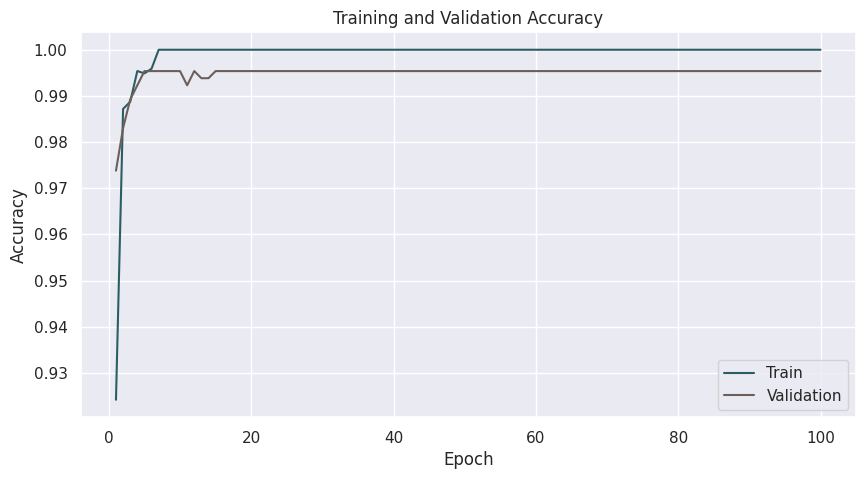

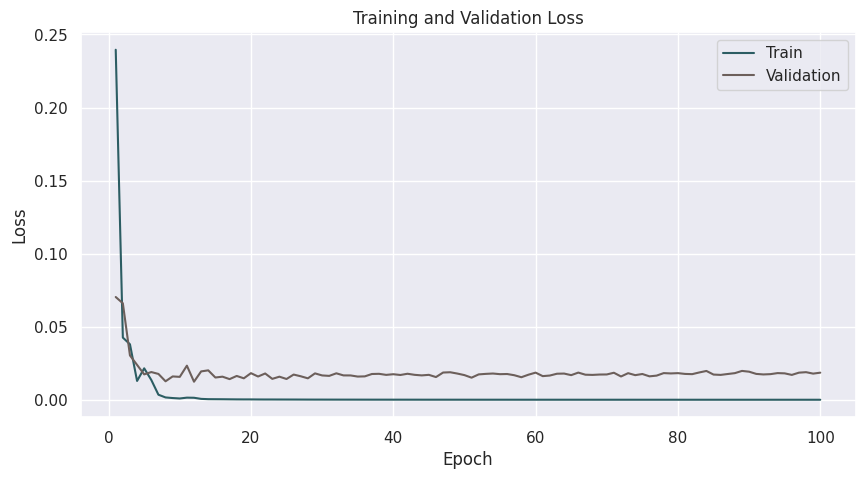

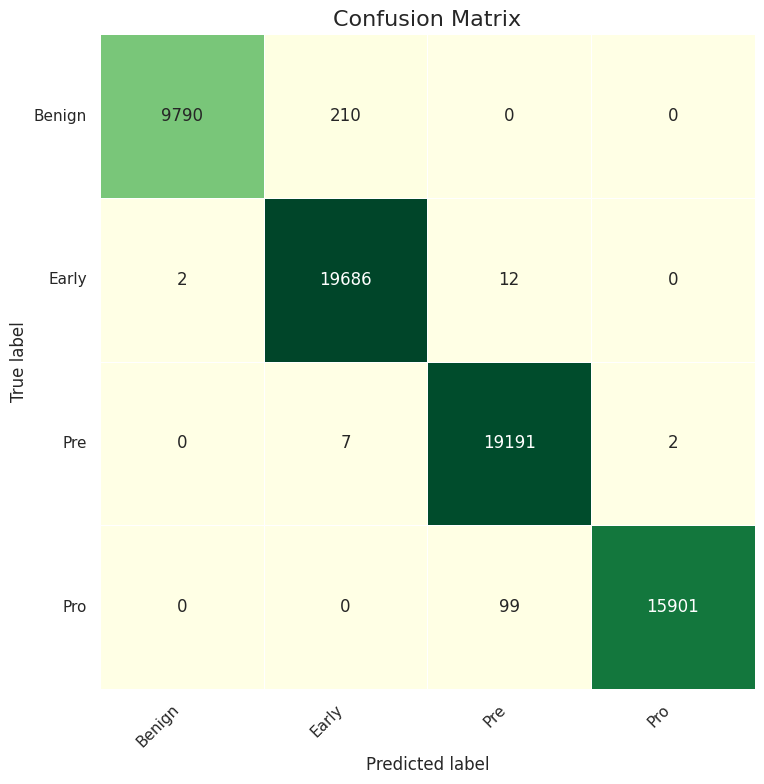

In [91]:
model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler)

example = torch.rand(1, 3, 224, 224)
traced_script_module = torch.jit.trace(model.cpu(), example)
traced_script_module.save("/kaggle/working/kvasir_vit224_E100_2class.pt")

In [94]:
import torch
import numpy as np
from tqdm import tqdm

# Assuming you have defined the 'device', 'classes', 'test_loader', 'criterion', and 'test_data_len' variables

model_path = "/kaggle/working/kvasir_vit224_E100_2class.pt"
model = torch.jit.load(model_path)
model = model.to(device)

test_loss = 0.0
class_correct = list(0 for _ in range(len(classes)))
class_total = list(0 for _ in range(len(classes)))
model.eval()

for data, target in tqdm(test_loader):
    data, target = data.to(device), target.to(device)
    with torch.no_grad():
        output = model(data)
        loss = criterion(output, target)
        test_loss += loss.item() * data.size(0)  # Accumulate the losses

    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# Check if the test_data_len is not zero before dividing
if test_data_len > 0:
    test_loss = test_loss / test_data_len
    print('Test Loss: {:.4f}'.format(test_loss))
else:
    print('Test Loss: N/A (test_data_len is zero)')

# Calculate and print accuracy
for i in range(len(classes)):
    if class_total[i] > 0:
        print("Test Accuracy of %5s: %2d%% (%2d/%2d)" % (
            classes[i], 100 * class_correct[i] / class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])
        ))
    else:
        print("Test accuracy of %5s: NA" % (classes[i]))

# Overall accuracy
total_correct = np.sum(class_correct)
total_samples = np.sum(class_total)
if total_samples > 0:
    overall_accuracy = 100. * total_correct / total_samples
    print('\nTest Accuracy : {:.4f} ({}/{})'.format(overall_accuracy, total_correct, total_samples))
else:
    print('Overall Test Accuracy: N/A (total_samples is zero)')


100%|██████████| 21/21 [00:05<00:00,  3.75it/s]

Test Loss: 0.0201
Test Accuracy of Benign: 98% (100/102)
Test Accuracy of Early: 98% (194/197)
Test Accuracy of   Pre: 100% (194/194)
Test Accuracy of   Pro: 100% (162/162)

Test Accuracy : 99.2366 (650/655)
